1: This Section loads all the required Libraries

In [1]:
import numpy as np
import glob
import random
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.layers.core import Flatten
from scipy import ndimage
import pandas as pd
import cv2
from math import ceil, floor
import matplotlib.patches as mpatches

## Step 0: Load The Data
2: This Section loads all the Training, Validation, Test data from pickel files.

In [2]:
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

## Step 1: Dataset Summary & Exploration and Include an exploratory visualization of the dataset
3: This Section assigns the variables all the Training, Validation, Test data from pickel files, and declarition of Variables required 
for this project.
Also shows the output of No of traning, validation, test and size of image 

In [3]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Train_accuracy = []
Validation_accuracy = []
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
input_data = tf.placeholder(tf.float32, (None,32,32,1))
keep_prob = tf.placeholder(tf.float32)
y = tf.placeholder(tf.int32, (None))
n_classes = tf.one_hot(y, 43)

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("Image Shape: {}", image_shape)
print("Training Set:" , len(X_train))
print("Validation Set:" , n_validation )
print("Test Set:" , n_test )
print("Number of classes =", n_classes)

Image Shape: {} (32, 32, 3)
Training Set: 34799
Validation Set: 4410
Test Set: 12630
Number of classes = Tensor("one_hot:0", dtype=float32)


Updated Image Shape: (32, 32, 3)
9


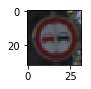

In [4]:
print("Updated Image Shape: {}".format(X_train[0].shape))
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

## Step 2: Design and Test a Model Architecture.
### Pre-process the Data Set
4: This Section is written all the required functions for preprocessing of images on traning and validation.splitdataset function is used to split images and corresponding classes wgich are low and want for which you want to preprocess images to generate more data. The normilization function is used to normilize images. The gray_images function is used to convert images to conver grascale. The down_images function is used to rescale images. The rescale_images function is used to crop and pad images. The counter_classes function is helpful for counting the no of images per classes. The image_process function is used as pipeline to generate images by performing padding, cropping, zoom in and zoom out. 

In [5]:
def splitdataset(imgs, classes, noclasses, count):
    i = 0
    j = 0
    newtraningset = []
    newclasses = []
    for i in range(len(noclasses)):
        if noclasses[i] <  count:
            for j in range(len(imgs)):
                if classes[j] == i: 
                    imagesset =  imgs[j]
                    newtraningset.append(imagesset)
                    newclasses.append(i)
    return newtraningset, newclasses
            
def normilization(imgs):
    normilize_out = []
    X = tf.placeholder(tf.float32, shape = (32,32,1))
    tf_img = tf.image.per_image_standardization(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in imgs:
            normilize_img = sess.run(tf_img, feed_dict = {X: img})
            normilize_out.append(normilize_img)
    normilize_out = np.array(normilize_out, dtype = np.float32)
    return normilize_out

def gray_images(imgs):
    gray_out = []
    X = tf.placeholder(tf.float32, shape = (32,32,3))
    tf_img = tf.image.rgb_to_grayscale(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in imgs:
            gray_img = sess.run(tf_img, feed_dict = {X: img})
            gray_out.append(gray_img)
    gray_out = np.array(gray_out, dtype = np.float32)
    return gray_out

def down_images(imgs, height, width):
    down_out = []
    X = tf.placeholder(tf.float32, shape = (None,None,3))
    tf_img = tf.image.resize_images(X, (height, width), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in imgs:
            down_img = sess.run(tf_img, feed_dict = {X: img})
            down_out.append(down_img)
    down_out = np.array(down_out, dtype = np.float32)
    return down_out

def rescale_images(imgs, height, width):
    transporse_out = []
    X = tf.placeholder(tf.float32, shape = (None,None,3))
    tf_img = tf.image.resize_image_with_crop_or_pad(X, height, width)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in imgs:
            transporse_img = sess.run(tf_img, feed_dict = {X: img})
            transporse_out.append(transporse_img)
    transporse_out = np.array(transporse_out, dtype = np.float32)
    return transporse_out

def counter_classes(ytrain):
    classes = []
    i = 0
    j = 0
    for i in range(43):
        count = 0
        for j in range(len(ytrain)):
            if ytrain[j] == i:
                count = count+1
        classes.append(count)
    return classes

def image_process(Xtrain, ytrain, valid_images):
    c_newa = []
    c_newb = []
    n_imagesa = []
    n_imagesb = []
    noclasses = counter_classes(ytrain)
    newimages, newclasses = splitdataset(Xtrain, ytrain, noclasses, 400)
    
    if valid_images == 1:  
        d_imagesa = down_images(newimages, 30, 30)
        n_imagesb.extend(d_imagesa)
        c_newb = np.tile(newclasses, 1)
        c_newa.extend(c_newb)
        c_newa.extend(ytrain)
    else:
        d_imagesa = down_images(newimages, 24, 24)
        d_imagesb = down_images(newimages, 26, 32)
        d_imagesc = down_images(newimages, 32, 26)
        d_imagesd = down_images(newimages, 26, 26)
        c_newb = np.tile(newclasses, 4)
        c_newa.extend(c_newb)
        c_newa.extend(ytrain)
        n_imagesb.extend(d_imagesa)
        n_imagesb.extend(d_imagesb)
        n_imagesb.extend(d_imagesc)
        n_imagesb.extend(d_imagesd)
    
    rescale_image = rescale_images(n_imagesb, 32,32)
    n_imagesa.extend(rescale_image)
    n_imagesa.extend(Xtrain)
    
    if valid_images == 0:
        no_classes = counter_classes(c_newa)
        n_images, n_classes = splitdataset(n_imagesa, c_newa, no_classes, 700)
        re_image = rescale_images(n_images, 24, 24)
        u_images = down_images(re_image, 32, 32) 
        n_imagesa.extend(u_images)
        c_newa.extend(n_classes)    
    
    ytrain = c_newa
    Xtrain = n_imagesa
    
    return Xtrain, ytrain

5: This Section shows the data before Preprocessing of images.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]
Image Shape: (32, 32, 3)
Training Set: 34799
classes Set: 34799
Validation Set: 4410
Test Set: 12630


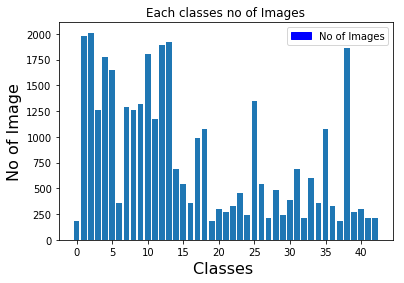

In [6]:
out_classesa = counter_classes(y_train)
print(out_classesa)
print("Image Shape: {}" .format(X_train[0].shape))
print("Training Set:" , len(X_train))
print("classes Set:" , len(y_train))
print("Validation Set:" , n_validation )
print("Test Set:" , n_test )
plt.bar(range(len(out_classesa)), out_classesa)
plt.title('Each classes no of Images')
plt.xlabel('Classes ',fontsize=16)
plt.xticks(np.arange(0, 43, step=5))
plt.ylabel('No of Image',fontsize=16)
patching = mpatches.Patch(color='b', label='No of Images')
plt.legend(handles=[patching])
plt.figure()
plt.show()

6: This Section is full pipeline for preprocessing images and get more data and try to balance classes. and later conert grayscale and perform normilization input data( Validation and Traning ).

In [7]:
X_train, y_train = image_process(X_train, y_train, 0)
X_valid, y_valid = image_process(X_valid, y_valid, 1)
X_train = gray_images(X_train)
X_valid = gray_images(X_valid)
X_train  = normilization(X_train)
X_valid = normilization(X_valid)

6: This Section shows the data after Preprocessing of images.

Image Shape: (32, 32, 1)
Training Set: 59308
classes Set: 59308
Validation Set: 8820
Test Set: 12630


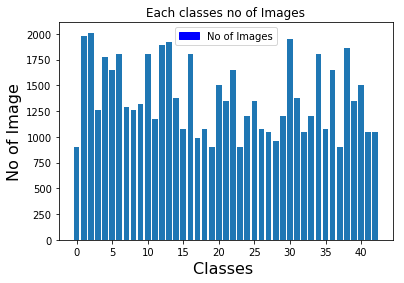

In [8]:
out_classesb = counter_classes(y_train)
print("Image Shape: {}" .format(X_train[0].shape))
print("Training Set:" , len(X_train))
print("classes Set:" , len(y_train))
print("Validation Set:" , len(X_valid) )
print("Test Set:" , len(X_test) )
plt.bar(range(len(out_classesb)), out_classesb)
plt.title('Each classes no of Images')
plt.xlabel('Classes ',fontsize=16)
plt.xticks(np.arange(0, 43, step=5))
plt.ylabel('No of Image',fontsize=16)
patching = mpatches.Patch(color='b', label='No of Images')
plt.legend(handles=[patching])
plt.figure()
plt.show()

7: This section shows the sampel of preprocessing data on new image.

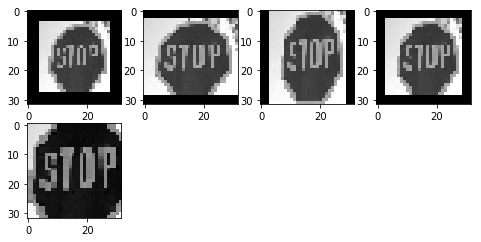

In [9]:
n_imagesa = []
n_imagesb = []
ima = []
image = cv2.imread ("C:/Users/pramo/Documents/Project2/stop.png")
image = cv2.resize(image, (32, 32), cv2.INTER_LINEAR)
images = np.array(image, dtype=np.uint8)
images = images.astype('float32')
ima.append (images)

d_imagesa = down_images(ima, 24, 24)
d_imagesb = down_images(ima, 26, 32)
d_imagesc = down_images(ima, 32, 26)
d_imagesd = down_images(ima, 26, 26)

n_imagesb.extend(d_imagesa)
n_imagesb.extend(d_imagesb)
n_imagesb.extend(d_imagesc)
n_imagesb.extend(d_imagesd)

r_image = rescale_images(n_imagesb, 32,32)
n_imagesa.extend(r_image)

re_image = rescale_images(ima, 24, 24)
u_images = down_images(re_image, 32, 32) 
n_imagesa.extend(u_images)
n_imagesa = gray_images(n_imagesa)
n_imagesa  = normilization(n_imagesa)

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(len(n_imagesa)):
    j= i+1
    img = n_imagesa[i].squeeze()
    fig.add_subplot(rows, columns, j)
    plt.imshow(img, cmap="gray")
plt.show()

8: This section shuffels the validation and traning data. 

In [10]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

### Model Architecture
9: This section No of Epochs, batch size is and learning rate is defined.

In [11]:
EPOCHS = 30
BATCH_SIZE = 128
rate = 0.0001

10: This section the convolution, maxpooling and fullyconnected functions are written. This functins are called or used whenever
the layer needs to defined. Convolution layer takes batches or previous layer output and Filter height, width and input depth of previous layer and outdepth is required. Maxpooling layer takes input of previous layer output. Fullyconnected layer layer takes input of previous layer output and no output required. 

In [12]:
def conv_layer(layer_input, filter_height, filter_width, input_depth, output_depth):
    mu = 0
    sigma = 0.1
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_height, filter_width, input_depth, output_depth), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(output_depth))
    conv   = tf.nn.conv2d(layer_input, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    conv = tf.nn.relu(conv)
    tf.summary.histogram("weight", conv_W)
    tf.summary.histogram("bias", conv_b)
    tf.summary.histogram("activation", conv)
    return conv

def maxpooling_layer(layer_input):
    return tf.nn.max_pool(layer_input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def fullyconnected_layer(layer_input, output_full):
    fc = tf.layers.dense(inputs=layer_input, units=output_full)
    fc = tf.nn.relu(fc)
    tf.summary.histogram("activation2", fc)
    return fc   

11: In this section all the layers defined.

In [13]:
def trafficNet(input_data):    
  
    # Layer 1: Convolutional. Input = 32x32x1, Output = 28x28x8.
    with tf.variable_scope("conv_a"):
        conv_layer_a = conv_layer(input_data, 5, 5, 1, 8) 
               
    # Layer 2: Convolutional Input = 28x28x16, Output = 24x24x16.
    with tf.variable_scope("conv_b"):
        conv_layer_b = conv_layer(conv_layer_a, 5, 5, 8, 16) 
    # Pooling. Input = 24x24x16, Output = 12x12x16.
    with tf.variable_scope("max_a"):
        conv_layer_b = maxpooling_layer(conv_layer_b) 
    
    # Layer 3: Convolutional. input = 12x12x16, Output = 8x8x64.
    with tf.variable_scope("conv_c"):
        conv_layer_c = conv_layer(conv_layer_b, 5, 5, 16, 64) 
    # Pooling. Input = 8x8x64, Output = 4x4x64.
    with tf.variable_scope("max_b"):
        conv_layer_c = maxpooling_layer(conv_layer_c)
    
    # Flatten. Input = 4x4x64. Output = 1024.
    with tf.variable_scope("flattern"):
        flat_a   = Flatten()(conv_layer_c)

    # Layer 4: Fully Connected. Input = 1024. Output = 512.
    with tf.variable_scope("dense_a"):
        fc_a   = fullyconnected_layer(flat_a, 512)
    with tf.variable_scope("drop_a"):
        fc_a   = tf.nn.dropout(fc_a, keep_prob)

    # Layer 5: Fully Connected. Input = 512. Output = 256.
    with tf.variable_scope("dense_b"):
        fc_b   = fullyconnected_layer(fc_a, 256)
    with tf.variable_scope("drop_b"):
        fc_b   = tf.nn.dropout(fc_b, keep_prob)
    
    # Layer 6: Fully Connected. Input = 256. Output = 128
    with tf.variable_scope("dense_c"):
        fc_c   = fullyconnected_layer(fc_b, 128)
    with tf.variable_scope("drop_c"):
        fc_c   = tf.nn.dropout(fc_c, keep_prob)

    # Layer 7 Fully Connected. Input = 128. Output = 43.
    with tf.variable_scope("dense_d"):
        fc_d   = fullyconnected_layer(fc_c, 43)
    
    return fc_d 

12: This section all the variables are defined to get out accuracy, predection ,probility , and optimizer used for traning.

In [14]:
traffic_sign = trafficNet(input_data)
with tf.variable_scope("cross_entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=n_classes, logits = traffic_sign)
with tf.variable_scope("loss_operation"):
    loss_operation = tf.reduce_mean(cross_entropy)
with tf.variable_scope("Adamoptimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
with tf.variable_scope("AdamoptimizerO/Pminimizer"):
    training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(traffic_sign, 1), tf.argmax(n_classes, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
classes_predection = (tf.cast(correct_prediction, tf.float32))
with tf.variable_scope("Softmax_problity"):
    softmax_prob = tf.nn.softmax(traffic_sign)
    
tf.summary.scalar("loss", loss_operation)
tf.summary.scalar("accuracy", accuracy_operation)

all_Summary_tf = tf.summary.merge_all()
saver = tf.train.Saver()

13: In this section eveulate function returns the accuracy, classpredection function returns 1 correct predction or 0 for wrong, softmax probility get the probility of input data. and tokK function get the top 5 probility for predection. 

In [15]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] 
        accuracy = sess.run(accuracy_operation, feed_dict={input_data: batch_x, y: batch_y, keep_prob: 1.0})            
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def class_predection(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] 
        classpredection = sess.run(classes_predection, feed_dict={input_data: batch_x, y: batch_y, keep_prob: 1.0})                    
    return classpredection

def softmax_problity(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] 
        softmaxproblity = sess.run(softmax_prob, feed_dict={input_data: batch_x, y: batch_y, keep_prob: 1.0})                    
    return softmaxproblity

def top_k(test): 
    sess = tf.get_default_session()   
    topk = sess.run(tf.nn.top_k(tf.constant(test), k=5))                
    return topk

def losses_data(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] 
        lossdata = sess.run(loss_operation, feed_dict={input_data: batch_x, y: batch_y, keep_prob: 1.0})                    
    return lossdata

### Train, Validate and Test the Model
14: This section the traning pipeline is defined, calculate accuracy, loss and gets output. 

Training...

EPOCH 1 ...
Traning Accuracy = 0.190 Validation Accuracy = 0.174 Validation loss = 3.531

EPOCH 2 ...
Traning Accuracy = 0.466 Validation Accuracy = 0.463 Validation loss = 2.445

EPOCH 3 ...
Traning Accuracy = 0.616 Validation Accuracy = 0.606 Validation loss = 1.690

EPOCH 4 ...
Traning Accuracy = 0.744 Validation Accuracy = 0.686 Validation loss = 1.224

EPOCH 5 ...
Traning Accuracy = 0.827 Validation Accuracy = 0.738 Validation loss = 0.949

EPOCH 6 ...
Traning Accuracy = 0.915 Validation Accuracy = 0.827 Validation loss = 0.715

EPOCH 7 ...
Traning Accuracy = 0.944 Validation Accuracy = 0.862 Validation loss = 0.574

EPOCH 8 ...
Traning Accuracy = 0.961 Validation Accuracy = 0.884 Validation loss = 0.461

EPOCH 9 ...
Traning Accuracy = 0.974 Validation Accuracy = 0.909 Validation loss = 0.331

EPOCH 10 ...
Traning Accuracy = 0.979 Validation Accuracy = 0.911 Validation loss = 0.285

EPOCH 11 ...
Traning Accuracy = 0.984 Validation Accuracy = 0.927 Validation loss = 0.

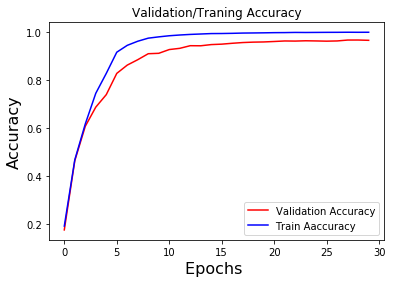

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    writer = tf.summary.FileWriter("C:/Users/pramo/Documents/Project2/logs/", sess.graph)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            summ, _ = sess.run([all_Summary_tf, training_operation], feed_dict={input_data: batch_x, y: batch_y, keep_prob: 0.4})   
            writer.add_summary(summ, i)
        train_accuracy = evaluate(X_train, y_train)        
        validation_accuracy = evaluate(X_valid, y_valid)      
        validation_loss = losses_data(X_valid, y_valid)
        Validation_accuracy.append(validation_accuracy)
        Train_accuracy.append(train_accuracy)
    
        print("EPOCH {} ...".format(i+1))
        print("Traning Accuracy = {:.3f}".format(train_accuracy),"Validation Accuracy = {:.3f}".format(validation_accuracy), "Validation loss = {:.3f}".format(validation_loss) )
        print()
        
    saver.save(sess, './trafficsign')
    print("Model saved")
    plt.plot(range(len(Validation_accuracy)), Validation_accuracy, 'r', label='Validation Accuracy')
    plt.plot(range(len(Train_accuracy)), Train_accuracy, 'b', label='Train Aaccuracy')
    plt.title('Validation/Traning Accuracy')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show() 

15: This section gets output accuracy on test images.

In [17]:
X_test = gray_images(X_test)
X_test = normilization(X_test)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\trafficsign
Test Accuracy = 0.959


## Step 3: Test a Model on New Images
### Predict the Sign Type for Each Image
### Analyze Performance

C:/Users/pramo/Documents/Project2\noentry.png
C:/Users/pramo/Documents/Project2\priority.png
C:/Users/pramo/Documents/Project2\slippery.png
C:/Users/pramo/Documents/Project2\speed70.png
C:/Users/pramo/Documents/Project2\stop.png
C:/Users/pramo/Documents/Project2\yield.png
INFO:tensorflow:Restoring parameters from ./trafficsign
[1. 1. 1. 1. 1. 1.]
1.0


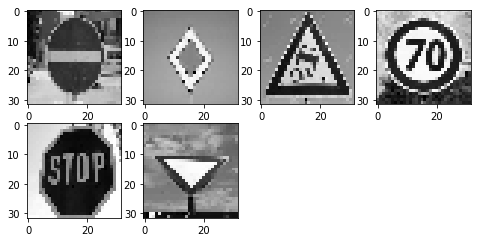

In [18]:
testimages = []
files = glob.glob ("C:/Users/pramo/Documents/Project2/*.PNG")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    image = cv2.resize(image, (32, 32), cv2.INTER_LINEAR)
    images = np.array(image, dtype=np.uint8)
    images = images.astype('float32')
    testimages.append (images)    
testimages = gray_images(testimages)
testimages  = normilization(testimages)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    yVal = np.array([17, 12, 23, 4, 14, 13])
    pred_accuracy = class_predection(testimages, yVal)
    new_accuracy = evaluate(testimages, yVal)
print(pred_accuracy)
print(new_accuracy)

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(len(testimages)):
    j= i+1
    img = testimages[i].squeeze()
    fig.add_subplot(rows, columns, j)
    plt.imshow(img, cmap="gray")
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web
16: This section Output Top 5 Softmax Probabilities For Each Image Found on the Web

C:/Users/pramo/Documents/Project2\noentry.png
C:/Users/pramo/Documents/Project2\priority.png
C:/Users/pramo/Documents/Project2\slippery.png
C:/Users/pramo/Documents/Project2\speed70.png
C:/Users/pramo/Documents/Project2\stop.png
C:/Users/pramo/Documents/Project2\yield.png
INFO:tensorflow:Restoring parameters from ./trafficsign
TopKV2(values=array([[1.00000000e+00, 2.08867794e-13, 1.05313382e-13, 2.49310511e-14,
        2.22550639e-14],
       [9.99992490e-01, 7.56726195e-06, 1.28644691e-16, 1.07359626e-16,
        6.11026407e-17],
       [9.88313675e-01, 5.80488425e-03, 2.62709870e-03, 1.28795765e-03,
        1.04666979e-03],
       [1.00000000e+00, 4.30863878e-09, 3.81032450e-09, 1.47926726e-10,
        1.17841681e-10],
       [9.99999881e-01, 1.08919394e-07, 4.19129265e-09, 2.13694573e-09,
        1.98499905e-09],
       [1.00000000e+00, 5.13328605e-15, 1.39614098e-18, 5.41570088e-19,
        4.29444774e-19]], dtype=float32), indices=array([[17,  8,  0, 38, 34],
       [12, 40, 32, 2

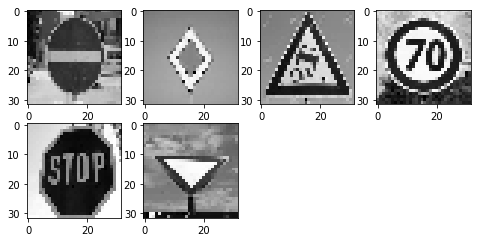

In [19]:
testimages = []
files = glob.glob ("C:/Users/pramo/Documents/Project2/*.PNG")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    image = cv2.resize(image, (32, 32), cv2.INTER_LINEAR)
    images = np.array(image, dtype=np.uint8)
    images = images.astype('float32')
    testimages.append (images)
testimages = gray_images(testimages)
testimages  = normilization(testimages)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    yVal = np.arange(0, 43, 1)
    test = softmax_problity(testimages, yVal)
    testaccuracy = top_k(test)
    print(testaccuracy)    
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(len(testimages)):
    j= i+1
    img = testimages[i].squeeze()
    fig.add_subplot(rows, columns, j)
    plt.imshow(img, cmap="gray")
plt.show()